credits: https://github.com/DrMatters/hyperoptsearchcv

In [1]:
import numpy as np
from hpscv import HyperoptSearchCV

from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

### 01 - Create classification dataset

In [2]:
X, y = make_classification(n_samples=1000, random_state=123)

print(X.shape, y.shape)

(1000, 20) (1000,)


### 02 - Create decision tree pipeline

In [3]:
pipe = Pipeline([
    ('selector', SelectKBest(f_classif, k='all')),
    ('estimator', DecisionTreeClassifier(random_state=123))
])

### 03 - KFold cross-validation

In [4]:
cv = KFold(n_splits=10, shuffle=True, random_state=123)

### 04 - Evaluate baseline

In [5]:
scores = cross_val_score(estimator=pipe, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=2, verbose=0)

print(scores)
print(scores.mean(), scores.std())

[0.99 0.96 0.98 0.97 1.   0.95 0.98 1.   0.97 0.97]
0.9770000000000001 0.015524174696260037


### 05 - Define optimization search space

In [6]:
from hyperopt import hp
from hyperopt.pyll.base import scope

search = {
    'selector__k': scope.int(hp.quniform('selector__k', 1, 20, 1)),
    
    'estimator__criterion': hp.choice('estimator__criterion', ['gini', 'entropy']),
    'estimator__max_depth': scope.int(hp.quniform('estimator__max_depth', 1, 30, 1)),
    'estimator__min_samples_split': scope.int(hp.quniform('estimator__min_samples_split', 2, 100, 1)),
    'estimator__min_samples_leaf': scope.int(hp.quniform('estimator__min_samples_leaf', 1, 100, 1)),
    'estimator__max_features': hp.choice('estimator__max_features', ['auto','sqrt','log2']),
    'estimator__min_impurity_decrease': hp.qloguniform('estimator__min_impurity_decrease', np.log(0.0001), np.log(10),0.0001)
}

In [7]:
import os
if os.path.exists(r'./trials.dat'):
    os.remove(r'./trials.dat')

### 06 - Run first 5 optimization executions

In [8]:
hpscv = HyperoptSearchCV(
    estimator=pipe,
    search_space=search, 
    n_iter=5, 
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1,
    greater_is_better=True,
    trials_path=r'./trials.dat'
)

In [9]:
_ = hpscv.fit(X, y)

-0.943 (2.65s) - mean score on CV with params {'estimator__criterion': 'entropy', 'estimator__max_depth': 21, 'estimator__max_features': 'auto', 'estimator__min_impurity_decrease': 0.004, 'estimator__min_samples_leaf': 8, 'estimator__min_samples_split': 84, 'selector__k': 10}
-0.654 (1.47s) - mean score on CV with params {'estimator__criterion': 'entropy', 'estimator__max_depth': 2, 'estimator__max_features': 'log2', 'estimator__min_impurity_decrease': 0.0038, 'estimator__min_samples_leaf': 93, 'estimator__min_samples_split': 73, 'selector__k': 9}
-0.475 (0.03s) - mean score on CV with params {'estimator__criterion': 'gini', 'estimator__max_depth': 16, 'estimator__max_features': 'auto', 'estimator__min_impurity_decrease': 5.703200000000001, 'estimator__min_samples_leaf': 31, 'estimator__min_samples_split': 89, 'selector__k': 17}
-0.585 (0.03s) - mean score on CV with params {'estimator__criterion': 'entropy', 'estimator__max_depth': 22, 'estimator__max_features': 'log2', 'estimator__mi

In [10]:
hpscv.best_score_

-0.943

In [11]:
hpscv.best_params_

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 21,
 'estimator__max_features': 'auto',
 'estimator__min_impurity_decrease': 0.004,
 'estimator__min_samples_leaf': 8,
 'estimator__min_samples_split': 84,
 'selector__k': 10}

### 07 - Run 95 more optimization executions

In [12]:
hpscv = HyperoptSearchCV(
    estimator=pipe,
    search_space=search, 
    n_iter=500, 
    scoring='accuracy',
    cv=cv,
    verbose=0,
    n_jobs=-1,
    greater_is_better=True,
    trials_path=r'./trials.dat'
)

_ = hpscv.fit(X, y)

100%|██████████| 500/500 [01:33<00:00,  5.32trial/s, best loss: -0.9880000000000001]
best params:  {'estimator__criterion': 'entropy', 'estimator__max_depth': 22, 'estimator__max_features': 'sqrt', 'estimator__min_impurity_decrease': 0.0006000000000000001, 'estimator__min_samples_leaf': 9, 'estimator__min_samples_split': 8, 'selector__k': 4}


In [13]:
hpscv.best_score_

-0.9880000000000001

In [14]:
hpscv.best_params_

{'estimator__criterion': 'entropy',
 'estimator__max_depth': 22,
 'estimator__max_features': 'sqrt',
 'estimator__min_impurity_decrease': 0.0006000000000000001,
 'estimator__min_samples_leaf': 9,
 'estimator__min_samples_split': 8,
 'selector__k': 4}

### 08 - Visualize search paths during optimization execution

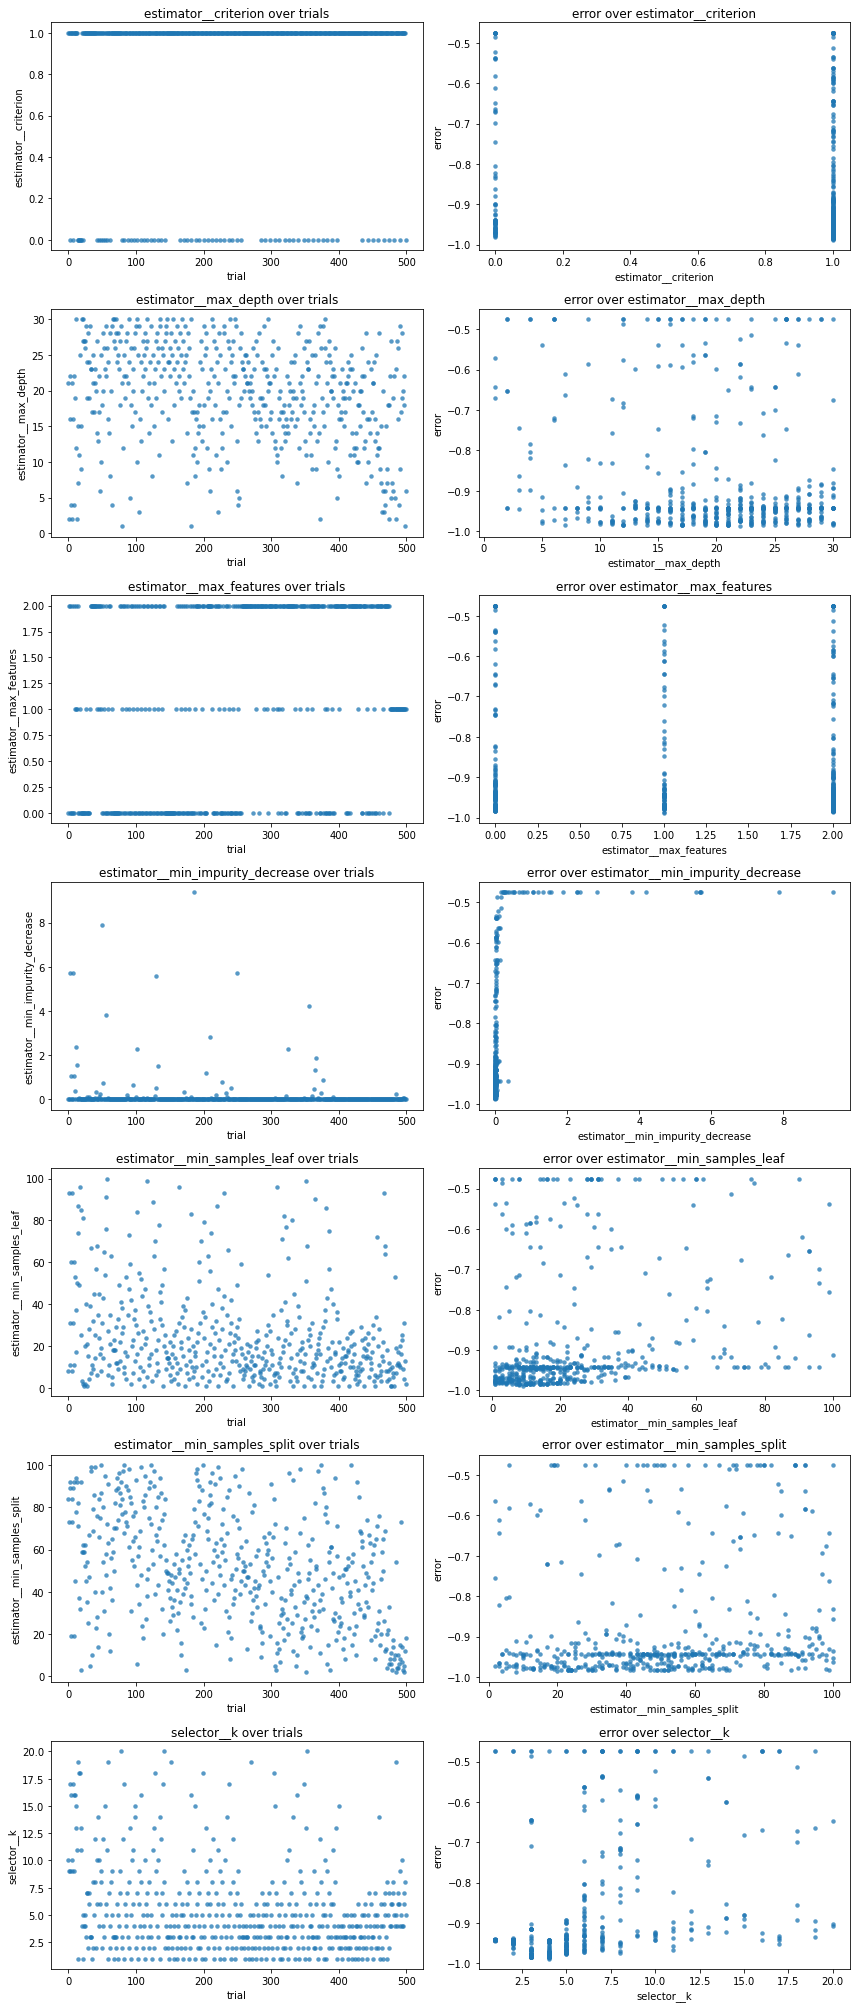

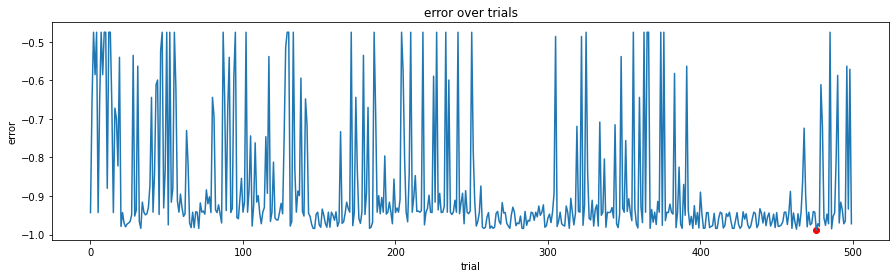

In [15]:
hpscv.visualize_trials()

### 09 - Use new optimized hyperparameters and evaluate final results

In [16]:
pipe.set_params(**hpscv.best_params_)

Pipeline(steps=[('selector', SelectKBest(k=4)),
                ('estimator',
                 DecisionTreeClassifier(criterion='entropy', max_depth=22,
                                        max_features='sqrt',
                                        min_impurity_decrease=0.0006000000000000001,
                                        min_samples_leaf=9, min_samples_split=8,
                                        random_state=123))])

In [17]:
scores = cross_val_score(estimator=pipe, X=X, y=y, scoring='accuracy', cv=cv, n_jobs=2, verbose=0)

print(scores)
print(scores.mean(), scores.std())

[0.99 0.98 0.99 0.99 1.   1.   0.98 0.99 0.98 0.98]
0.9880000000000001 0.007483314773547889
